In [ ]:
"""

- Business Problem
Amazon üzerinden satışlarını gerçekleştiren ev tekstili ve günlük giyim odaklı üretimler yapan Kozmos ürünlerine
gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir.
Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlencek ve etiketlenen veri ile sınıflandırma modeli
oluşturulacaktır. 

- Amacımız : Amazonda ürünlere yapılan yorumlara duygu analizi yaparak makine öğrenmesi modeli oluşturmak.Metin sınıflandırma 
modeli oluştururuz.Bu modele yeni yorumlar sorularak ilgili yorumun pozitif,negatif olduğunu döndürülür.Böylece ilgili 
yorumları analiz edebiliriz.

- Veri Seti Hikayesi
Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu
kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.

Review: Ürüne yapılan yorum
Title: Yorum içeriğine verilen başlık, kısa yorum
HelpFul: Yorumu faydalı bulan kişi sayısı
Star: Ürüne verilen yıldız sayısı

"""

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

## Text Preprocessing (Metin Ön İşleme)

In [3]:
df = pd.read_excel("amazon.xlsx")

In [4]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [ ]:
# Normalizing Case Folding
# a. Tüm harfleri küçük harfe çeviririz


In [6]:
df['Review'] = df['Review'].str.lower()

In [ ]:
# Punctuations
# b. Noktalama işaretlerini çıkarırız

In [7]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [ ]:
# Numbers 
# c. Yorumlarda bulunan sayısal ifadeleri çıkarıp boşluk ile değiştiririz

In [8]:
df['Review'] = df['Review'].str.replace('\d', '')

In [ ]:
# Stopwords
# d. Bilgi içermeyen kelimeleri (stopwords) veriden çıkarırız

In [9]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Cansu
[nltk_data]     Teymur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [ ]:
# Rarewords / Custom Words
# e. 1000'den az geçen kelimeleri veriden çıkarırız

In [11]:
sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [ ]:
# Lemmatization
# f. Kelimeleri köklerine ayırmak.

In [12]:
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to C:\Users\Cansu
[nltk_data]     Teymur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df['Review'].head(10)

0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
5                                 look different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtain would thinner ...
8    much whiter thought would wasnt really expecti...
9    curtain picture show rd set ambesonne curtain ...
Name: Review, dtype: object

## Text Visualization (Metin Görselleştirme)

In [ ]:
"""
- Görselleştirme işlemleri ile metin setinden anlamlı bilgiler çıkarabiliriz.

- Barplot görselleştirme işlemi
        "Review" değişkeninin içerdiği kelimelerin frekanslarını hesaplayıp "tf" olarak kaydederiz,"tf" değişkeninde değeri 
         500'den fazla olanlara göre filtreleme işlemi yaparak görselleştiririz.
"""

In [14]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [15]:
tf.columns = ["words", "tf"]

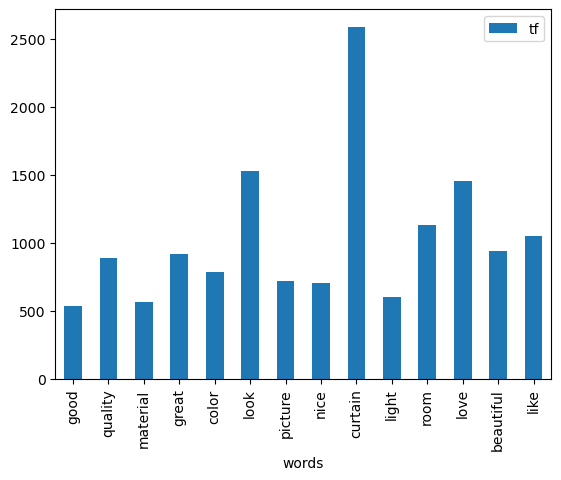

In [16]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

In [ ]:
"""
WordCloud görselleştirme işlemi
         a. "Review" değişkeninin içerdiği tüm kelimeleri "text" isminde string olarak kaydediriz.
         b. WordCloud kullanarak şablon şeklini belirleyip kaydediriz.
         c. Kaydettiğimiz wordcloud'u ilk adımda oluşturduğumuz string ile generate ederiz.
         d. Görselleştirme adımlarını tamamlarız. (figure, imshow, axis, show)
"""

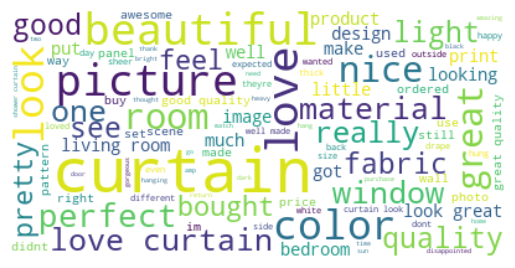

In [17]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Duygu Analizi

In [18]:
sia = SentimentIntensityAnalyzer()

In [ ]:
"""
SentimentIntensityAnalyzer nesnesi ile polarite puanlarının incelenmesi
                 a. "Review" değişkeninin ilk 10 gözlemi için polarity_scores() hesaplarız.
                 b. İncelenen ilk 10 gözlem için compund skorlarına göre filtrelenerek tekrar gözlemleriz.
                 c. 10 gözlem için compound skorları 0'dan büyükse "pos" değilse "neg" şeklinde güncelleriz.
                 d. "Review" değişkenindeki tüm gözlemler için pos-neg atamasını yaparak yeni bir değişken olarak dataframe'e 
                 ekleriz.
"""

In [19]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
2    {'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.517, 'pos': 0.483, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [20]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [21]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [22]:
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [ ]:
# star : ürüne verilen puanlar
# neg ve pos yorumların aldığı puanlar arasında farklılıklar var.
# sentiment_label değişkeni ML modeli için oluşturulan bağımlı değişken(hedef değişken)

In [23]:
df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64

## Makine öğrenmesine hazırlık!

In [ ]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train,test olarak ayırırız.
# Bağımlı değişken: Sentiment_Label     
# Bağımsız değişken: Review

In [24]:
# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

In [ ]:
"""
Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekiyor.
            a. TfidfVectorizer kullanarak bir nesne oluştururuz.
            b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ederiz.
            c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediriz.
"""

In [25]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)

In [26]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)

In [27]:
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

## Modelleme (Lojistik Regresyon)

In [ ]:
# Lojistik regresyon modelini kurarak train dataları ile fit ederiz.

In [28]:
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)

In [ ]:
"""
Kurmuş olduğumuz model ile tahmin işlemleri gerçekleştiririz.
         a. Predict fonksiyonu ile test datasını tahmin ederek kaydediriz.
         b. classification_report ile tahmin sonuçlarını raporlayıp gözlemleriz.
         c. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplarız.
"""

In [29]:
y_pred = log_model.predict(x_test_tf_idf_word)

In [30]:
print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [31]:
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

0.8546034570411795

In [ ]:
"""

- ML modeli ile gelen ürün yorumunun pozitif,negatif olduğunu tahmin edecektik.Modelimiz %85 accuracy değerine sahip yani 
gelen ürün yorumunu %85 başarı ile doğru tahmin ederiz.

- Veride bulunan yorumlardan ratgele seçerek modele sorulması.
         a. sample fonksiyonu ile "Review" değişkeni içerisinden örneklem seçerek yeni bir değere atarız.
         b. Elde ettiğimiz örneklemi modelin tahmin edebilmesi için CountVectorizer ile vektörleştiririz.
         c. Vektörleştirdiğimiz örneklemi fit ve transform işlemlerini yaparak kaydediriz.
         d. Kurmuş olduğumuz modele örneklemi vererek tahmin sonucunu kaydediriz.
         e. Örneklemi ve tahmin sonucunu ekrana yazdırırız.

"""

In [32]:
random_review = pd.Series(df["Review"].sample(1).values)

In [33]:
yeni_yorum = CountVectorizer().fit(train_x).transform(random_review)

In [34]:
pred = log_model.predict(yeni_yorum)

In [36]:
print(f'Review:  {random_review[0]} \nPrediction: {pred}')

Review:  ugly 
Prediction: ['neg']


## Modelleme (Random Forest)

In [ ]:
"""
Random Forest modeli ile tahmin sonuçlarının gözlenmesi;
          a. RandomForestClassifier modelini kurup fit ederiz.
          b. cross validation fonksiyonunu kullanarak ortalama accuracy değerini hesaplarız.

"""

In [37]:
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)

In [38]:
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8923741738688358